#Example hologram processing pipeline

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import os

from pyopia.classify import Classify
import pyopia.process
import pyopia.io
import pyopia.background
import pyopia.statistics
import exampledata
from pyopia.pipeline import Pipeline
import pyopia.instrument.holo as holo

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#download the default holo test data and create file list
foldername = exampledata.get_folder_from_holo_repository()


In [9]:
# example future pre-processing admin:
# 1) config file config load
# 2) build steps dict from loaded file
# 3) establish non-processing related metadata

foldername = 'holo_test_data_01'

os.makedirs('proc', exist_ok=True)

datafile_hdf = 'proc/holotest'
if os.path.exists(datafile_hdf + '-STATS.h5'):
  os.remove(datafile_hdf + '-STATS.h5')

model_path = exampledata.get_example_model()
threshold = 0.9

average_window = 10  # number of images to use as background

files = glob(os.path.join(foldername, '*.pgm'))
bgfiles = files[:average_window] 

holo_initial_settings = {'pixel_size': 4.4, # pixel size in um
                        'wavelength': 658, # laser wavelength in nm
                        'minZ': 22, # minimum reconstruction distance in mm
                        'maxZ': 60, # maximum reconstruction distance in mm
                        'stepZ': 2} #step size in mm

steps = {'initial': holo.Initial(files[0], **holo_initial_settings),
         'classifier': Classify(model_path=model_path),
         'create background': pyopia.background.CreateBackground(bgfiles,
                                                                 pyopia.instrument.holo.load_image),
         'load': holo.Load(),
         'correct background': pyopia.background.CorrectBackgroundAccurate(pyopia.background.shift_bgstack_accurate),
         'reconstruct': holo.Reconstruct(stack_clean=0),
         'segmentation': pyopia.process.Segment(threshold=threshold),
         'statextract': pyopia.process.CalculateStats(),
         'output': pyopia.io.StatsH5(datafile_hdf)}

processing_pipeline = Pipeline(steps)


Initialising pipeline
  Running <pyopia.instrument.holo.Initial object at 0x7f9e57727a30>
Using first raw file to determine image dimensions
Build kernel
HoloInitial done 2023-01-11 23:51:39.698126
  Running <pyopia.classify.Classify object at 0x7f9e5789a220>
Pipeline ready with these data:  ['kern', 'cl']


In [10]:
#do a test run with just the first few input files
for filename in files[:5]:
    stats = processing_pipeline.run(filename)

calling:  <class 'pyopia.background.CreateBackground'>  with:  ['kern', 'cl', 'filename', 'steps_string']
calling:  <class 'pyopia.instrument.holo.Load'>  with:  ['kern', 'cl', 'filename', 'steps_string', 'bgstack', 'imbg']
calling:  <class 'pyopia.background.CorrectBackgroundAccurate'>  with:  ['kern', 'cl', 'filename', 'steps_string', 'bgstack', 'imbg', 'timestamp', 'imraw']
calling:  <class 'pyopia.instrument.holo.Reconstruct'>  with:  ['kern', 'cl', 'filename', 'steps_string', 'bgstack', 'imbg', 'timestamp', 'imraw', 'imc']
forward transform
inverse transform
clean stack
summarise stack
calling:  <class 'pyopia.process.Segment'>  with:  ['kern', 'cl', 'filename', 'steps_string', 'bgstack', 'imbg', 'timestamp', 'imraw', 'imc']
segment
clean
calling:  <class 'pyopia.process.CalculateStats'>  with:  ['kern', 'cl', 'filename', 'steps_string', 'bgstack', 'imbg', 'timestamp', 'imraw', 'imc', 'imbw']
statextract_light
0.7% saturation
measure
  47 particles found
WARNING. exportparticles t

In [11]:

# display metadata in the h5
pyopia.io.show_h5_meta(datafile_hdf + '-STATS.h5')

Modified:
    2023-01-11 23:52:05.506264
Pipeline steps:
    
1) Step: initial
   Type: <class 'pyopia.instrument.holo.Initial'>
   Vars: {'filename': 'holo_test_data_01/001-2085.pgm', 'pixel_size': 4.4, 'wavelength': 658, 'minZ': 22, 'maxZ': 60, 'stepZ': 2}
2) Step: classifier
   Type: <class 'pyopia.classify.Classify'>
   Vars: {'model_path': 'keras_model.h5', 'class_labels': Index(['oil', 'other', 'bubble', 'faecal_pellets', 'copepod', 'diatom_chain',
       'oily_gas'],
      dtype='object'), 'model': <keras.engine.sequential.Sequential object at 0x7f9e5789a610>}
3) Step: create background
   Type: <class 'pyopia.background.CreateBackground'>
   Vars: {'bgfiles': ['holo_test_data_01/001-2085.pgm', 'holo_test_data_01/001-2084.pgm', 'holo_test_data_01/001-2079.pgm', 'holo_test_data_01/001-2044.pgm', 'holo_test_data_01/001-2078.pgm', 'holo_test_data_01/001-2083.pgm', 'holo_test_data_01/001-2097.pgm', 'holo_test_data_01/001-2108.pgm', 'holo_test_data_01/001-2109.pgm', 'holo_test_data_0

In [12]:
# load the stats DataFrame from the h5 file
stats = pd.read_hdf(datafile_hdf + '-STATS.h5', 'ParticleStats/stats')
print('stats header: ', stats.columns)
print('Total number of particles: ', len(stats))

stats header:  Index(['major_axis_length', 'minor_axis_length', 'equivalent_diameter',
       'solidity', 'minr', 'minc', 'maxr', 'maxc', 'probability_oil',
       'probability_other', 'probability_bubble', 'probability_faecal_pellets',
       'probability_copepod', 'probability_diatom_chain',
       'probability_oily_gas', 'export name', 'timestamp', 'saturation'],
      dtype='object')
Total number of particles:  210


Text(0, 0.5, 'Volume Distribution [uL/sample vol.]')

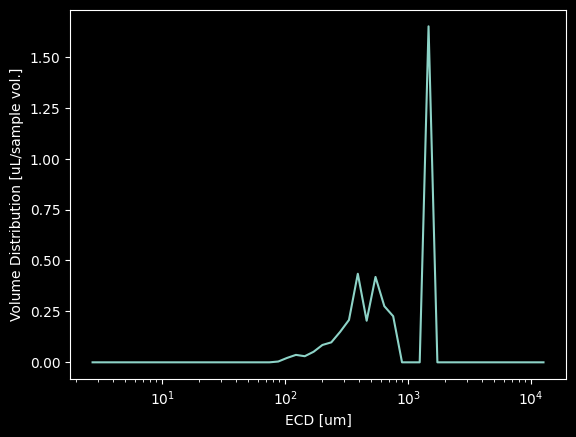

In [15]:
# Calculate the volume distribution from the stats DataFrame.
dias, vd = pyopia.statistics.vd_from_stats(stats, 24)

# plot the volume distribution
plt.style.use('dark_background')
plt.plot(dias, vd)
plt.xscale('log')
plt.xlabel('ECD [um]')
plt.ylabel('Volume Distribution [uL/sample vol.]')